Related urls, will remove once finished:
- https://www.tensorflow.org/tutorials/structured_data/time_series#multi-step_models

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools
from sklearn.preprocessing import StandardScaler
import sys
from pathlib import Path

parent_dir = Path.cwd().parent.parent

if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.metrics import print_evaluation_metrics
from shared.helpers import store_model
from shared.lstm import create_data

2024-05-02 19:34:17.845356: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-02 19:34:17.969153: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 19:34:17.969204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 19:34:17.986549: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-02 19:34:18.024246: I tensorflow/core/platform/cpu_feature_guar

In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "period"
target_column = "value"
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column, "value_30_hours_ago"]]

df = df.groupby(date_column).sum().reset_index()
df.set_index(date_column, inplace=True)
df = df.dropna()
dates = df.index.values

In [3]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_data.shape

(11467, 2)

In [4]:

X_train, X_test, X_val, y_train, y_test, y_val = create_data(
    scaled_data,
    n_future=1,
    n_past=24,
    train_test_split_percentage=0.9,
    validation_split_percentage=0,
)

In [5]:
X_test[0]

array([[-1.07996064, -0.14552208],
       [-1.0515213 , -0.33471926],
       [-0.91548576, -0.56529467],
       [-0.63663528, -0.77480791],
       [-0.35087749, -0.93746419],
       [-0.24242853, -1.06594773],
       [-0.19635851, -1.11824077],
       [-0.15497863, -1.08679673],
       [-0.1379662 , -0.93641961],
       [-0.14058841, -0.62931261],
       [-0.11332161, -0.35392678],
       [-0.08588426, -0.25974388],
       [-0.06373398, -0.19075886],
       [ 0.01205451, -0.14524494],
       [ 0.1295853 , -0.11360904],
       [ 0.19863703, -0.11738233],
       [ 0.20733512, -0.10542293],
       [ 0.14252584, -0.08404099],
       [ 0.00160828, -0.06329858],
       [-1.16856176, -0.02816653],
       [-0.47241622,  0.0645241 ],
       [-0.69417484,  0.12351099],
       [-0.93968265,  0.11489852],
       [-1.0567231 ,  0.04235339]])

In [9]:
import json

def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    (
        first_additional_layer,
        second_additional_layer,
        third_additional_layer,
        n_neurons,
        n_batch_size,
        dropout,
    ) = config
    possible_combinations = list(
        itertools.product(
            first_additional_layer,
            second_additional_layer,
            third_additional_layer,
            n_neurons,
            n_batch_size,
            dropout,
        )
    )

    print(possible_combinations)
    print("\n")

    hist = []

    for i in range(0, len(possible_combinations)):
        print(f"{i+1}th combination: \n")
        print("--------------------------------------------------------------------")

        (
            first_additional_layer,
            second_additional_layer,
            third_additional_layer,
            n_neurons,
            n_batch_size,
            dropout,
        ) = possible_combinations[i]

        regressor = Sequential()
        regressor.add(
            LSTM(
                units=n_neurons,
                return_sequences=True,
                input_shape=(x_train.shape[1], x_train.shape[2]),
            )
        )
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation="linear"))
        regressor.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )

        es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

        file_path = "best_model.h5"

        mc = ModelCheckpoint(
            file_path, monitor="val_loss", mode="min", verbose=1, save_best_only=True
        )

        regressor.fit(
            x_train,
            y_train,
            validation_split=0.3,
            epochs=1000,
            batch_size=n_batch_size,
            callbacks=[es, mc],
            verbose=0,
        )

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(
            list(
                (
                    first_additional_layer,
                    second_additional_layer,
                    third_additional_layer,
                    n_neurons,
                    n_batch_size,
                    dropout,
                    train_accuracy,
                    test_accuracy,
                )
            )
        )
        print(
            f"{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}"
        )

    return hist

In [10]:
config = [
    [True, False],
    [True, False],
    [True, False],
    [64, 128, 256],
    [24, 7*24],
    [0.2],
]

hist = LSTM_HyperParameter_Tuning(
    config, X_train, y_train, X_test, y_test
)

[(True, True, True, 64, 24, 0.2), (True, True, True, 64, 168, 0.2), (True, True, True, 128, 24, 0.2), (True, True, True, 128, 168, 0.2), (True, True, True, 256, 24, 0.2), (True, True, True, 256, 168, 0.2), (True, True, False, 64, 24, 0.2), (True, True, False, 64, 168, 0.2), (True, True, False, 128, 24, 0.2), (True, True, False, 128, 168, 0.2), (True, True, False, 256, 24, 0.2), (True, True, False, 256, 168, 0.2), (True, False, True, 64, 24, 0.2), (True, False, True, 64, 168, 0.2), (True, False, True, 128, 24, 0.2), (True, False, True, 128, 168, 0.2), (True, False, True, 256, 24, 0.2), (True, False, True, 256, 168, 0.2), (True, False, False, 64, 24, 0.2), (True, False, False, 64, 168, 0.2), (True, False, False, 128, 24, 0.2), (True, False, False, 128, 168, 0.2), (True, False, False, 256, 24, 0.2), (True, False, False, 256, 168, 0.2), (False, True, True, 64, 24, 0.2), (False, True, True, 64, 168, 0.2), (False, True, True, 128, 24, 0.2), (False, True, True, 128, 168, 0.2), (False, True, T

/home/samuell/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.28764 to 0.28448, saving model to best_model.h5

Epoch 3: val_loss improved from 0.28448 to 0.27001, saving model to best_model.h5

Epoch 4: val_loss improved from 0.27001 to 0.20226, saving model to best_model.h5

Epoch 5: val_loss improved from 0.20226 to 0.14938, saving model to best_model.h5

Epoch 6: val_loss improved from 0.14938 to 0.10194, saving model to best_model.h5

Epoch 7: val_loss did not improve from 0.10194

Epoch 8: val_loss improved from 0.10194 to 0.06130, saving model to best_model.h5

Epoch 9: val_loss did not improve from 0.06130

Epoch 10: val_loss did not improve from 0.06130

Epoch 11: val_loss improved from 0.06130 to 0.05134, saving model to best_model.h5

Epoch 12: val_loss did not improve from 0.05134

Epoch 13: val_loss did not improve from 0.05134

Epoch 14: val_loss did not improve from 0.05134

Epoch 15: val_loss improved from 0.05134 to 0.04906, saving model to best_model.h5

Epoch 16: val_loss did not improve from 0

In [11]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
5,True,True,True,256,168,0.2,"[0.023924177512526512, 0.15467442572116852]","[0.012632264755666256, 0.1123933494091034]"
35,False,True,False,256,168,0.2,"[0.019960660487413406, 0.14128220081329346]","[0.013028744608163834, 0.11414352804422379]"
41,False,False,True,256,168,0.2,"[0.018835026770830154, 0.13724076747894287]","[0.013173623941838741, 0.11477641016244888]"
47,False,False,False,256,168,0.2,"[0.01876676268875599, 0.13699182868003845]","[0.01319381408393383, 0.11486432701349258]"
36,False,False,True,64,24,0.2,"[0.020548639819025993, 0.14334796369075775]","[0.013324094004929066, 0.11543004214763641]"
30,False,True,False,64,24,0.2,"[0.01853359118103981, 0.13613812625408173]","[0.013324140571057796, 0.11543024331331253]"
44,False,False,False,128,24,0.2,"[0.01870042085647583, 0.1367494761943817]","[0.013353693298995495, 0.1155581846833229]"
15,True,False,True,128,168,0.2,"[0.023436684161424637, 0.1530904471874237]","[0.01344700250774622, 0.11596120893955231]"
17,True,False,True,256,168,0.2,"[0.0201969426125288, 0.14211595058441162]","[0.013523740693926811, 0.11629161983728409]"
29,False,True,True,256,168,0.2,"[0.0208221934735775, 0.1442989706993103]","[0.01359577476978302, 0.11660092324018478]"


In [12]:
print(
    f"Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}"
)

Best Combination: 
 first_additional_layer = True
 second_additional_layer = True
 third_additional_layer = True
 n_neurons = 256
 n_batch_size = 168
 dropout = 0.2
**************************
Results Before Tunning:
 Test Set RMSE: 0.1245

Results After Tunning:
 Test Set RMSE: 0.1124

10.0% Improvement


In [13]:
(
    first_additional_layer,
    second_additional_layer,
    third_additional_layer,
    n_neurons,
    n_batch_size,
    dropout,
) = [False, True, False, 256, 7, 0.2]

In [14]:
list(hist.iloc[0, :-2])

[True, True, True, 256, 168, 0.2]

In [15]:
regressor = Sequential()
regressor.add(
    LSTM(
        units=n_neurons,
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2]),
    )
)
regressor.add(Dropout(dropout))

if first_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if second_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if third_additional_layer:
    regressor.add(GRU(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=n_neurons, return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=1, activation="linear"))
regressor.compile(optimizer=tf.keras.optimizers.Adam(), loss="mse")

es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

file_path = "best_model.h5"

mc = ModelCheckpoint(
    file_path, monitor="val_loss", mode="min", verbose=1, save_best_only=True
)

regressor.fit(
    X_train,
    y_train,
    validation_split=0.3,
    epochs=200,
    batch_size=n_batch_size,
    callbacks=[es, mc],
    verbose=0,
)


Epoch 1: val_loss improved from inf to 0.05001, saving model to best_model.h5


/home/samuell/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.05001 to 0.03563, saving model to best_model.h5

Epoch 3: val_loss did not improve from 0.03563

Epoch 4: val_loss did not improve from 0.03563

Epoch 5: val_loss improved from 0.03563 to 0.03560, saving model to best_model.h5

Epoch 6: val_loss did not improve from 0.03560

Epoch 7: val_loss did not improve from 0.03560

Epoch 8: val_loss did not improve from 0.03560

Epoch 9: val_loss did not improve from 0.03560

Epoch 10: val_loss did not improve from 0.03560
Epoch 10: early stopping


In [9]:
regressor.evaluate(X_test, y_test)

36/36 [==============================] - 2s 32ms/step - loss: 0.0143


0.014313465915620327

In [10]:
y_pred = regressor.predict(X_test)

36/36 [==============================] - 2s 32ms/step


In [11]:
non_zero = []
scaler = StandardScaler()
scaler.fit(df[[target_column]])
unscaled_y_pred = scaler.inverse_transform([y_pred.flatten()])[0]
unscaled_y_test = scaler.inverse_transform([y_test.flatten()])[0]
unscaled_y_train = scaler.inverse_transform([y_train.flatten()])[0]
for i in unscaled_y_pred:
    removed_initial_one = i-1
    if removed_initial_one == 0:
        non_zero.append(removed_initial_one+sys.float_info.min)
    else:
        non_zero.append(removed_initial_one)

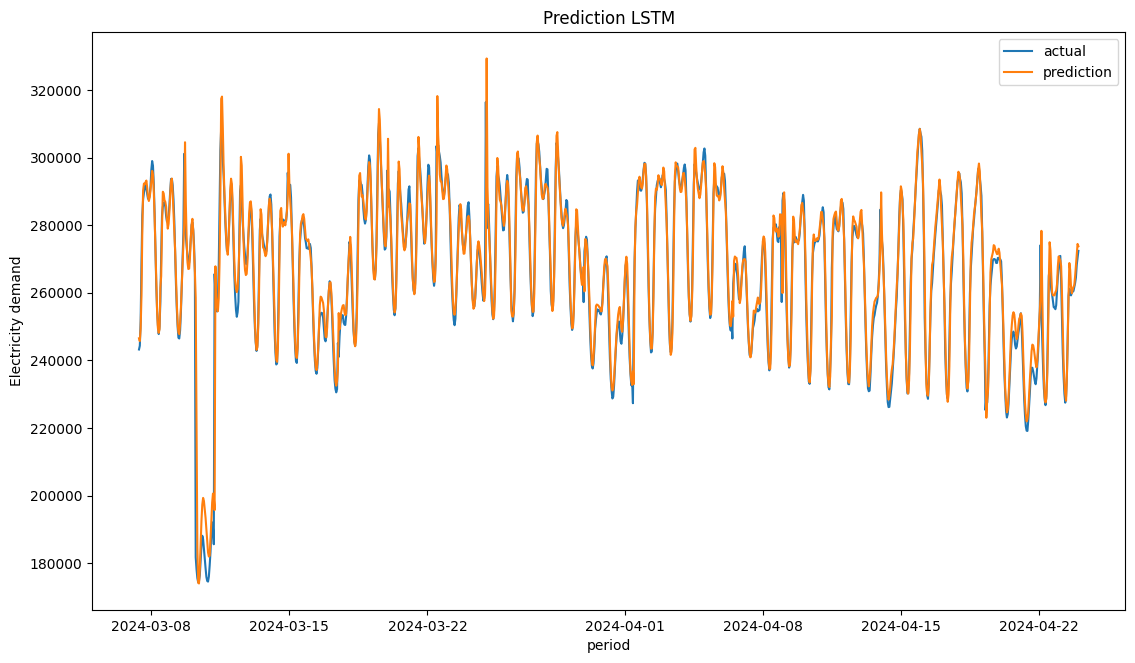

In [14]:


import matplotlib.dates as mdates
data_length = len(unscaled_y_test)

fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(pd.to_datetime(dates[-data_length:]), unscaled_y_test-1, label="actual")
ax.plot(pd.to_datetime(dates[-data_length:]), non_zero, label="prediction")
ax.set_title("Prediction LSTM")
ax.set_ylabel("Electricity demand")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()

In [20]:
print_evaluation_metrics(unscaled_y_pred, unscaled_y_test-1, unscaled_y_train-1)

Evaluation Metrics:
MSE: 31494807.48
RMSE: 5612.02
MAE: 2929.62
MAPE: 1.14
SMAPE: 1.13
MASE: 0.40


In [21]:
store_model(regressor, "lstm")